Chargement du dataset Iris...
Aperçu des données Iris:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
Dimensions du dataset: (150, 4)
Nombre réel d'espèces dans le dataset: 3 (setosa, versicolor, virginica)

Normalisation des données...

=== Détermination du nombre optimal de clusters ===


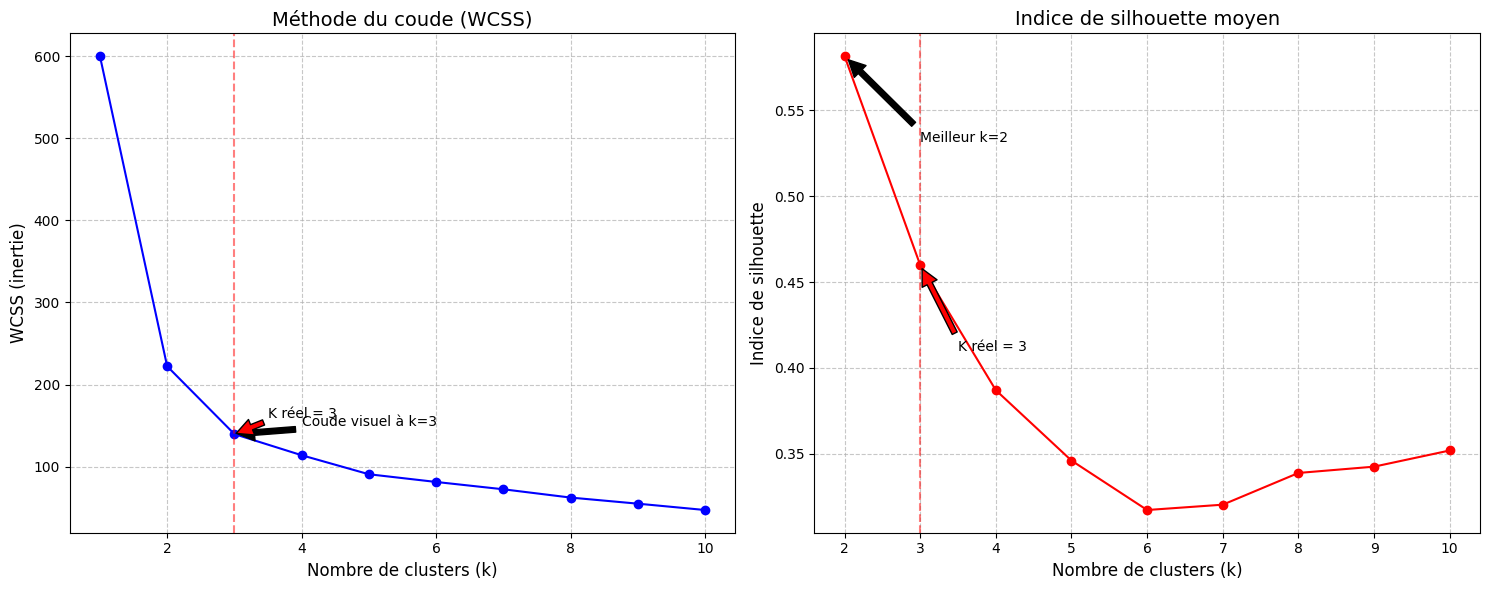


Résultats de l'analyse:
K | WCSS (inertie) | Silhouette
----------------------------------------
1 | 600.00 | 0.0000
2 | 222.36 | 0.5818
3 | 139.82 | 0.4599
4 | 114.09 | 0.3869
5 | 90.93 | 0.3459
6 | 81.54 | 0.3171
7 | 72.63 | 0.3202
8 | 62.54 | 0.3387
9 | 55.12 | 0.3424
10 | 47.39 | 0.3518

Méthode du coude: K optimal = 3
Méthode de la silhouette: K optimal = 2
Nombre réel d'espèces: 3
La méthode du coude identifie correctement le nombre réel d'espèces (K=3).
La méthode de la silhouette suggère K=2, ce qui diffère du nombre réel.
Nous retenons K=3 basé sur la connaissance du dataset et la méthode du coude.

Nombre optimal de clusters retenu: K=3

=== Tests avec K = 3 ===

Notre implémentation de K-means:
Adjusted Rand Index: 0.5923
Inertie: 140.0328
Score de silhouette: 0.4630

Implémentation scikit-learn de K-means:
Adjusted Rand Index: 0.6201
Inertie: 139.8205
Score de silhouette: 0.4599


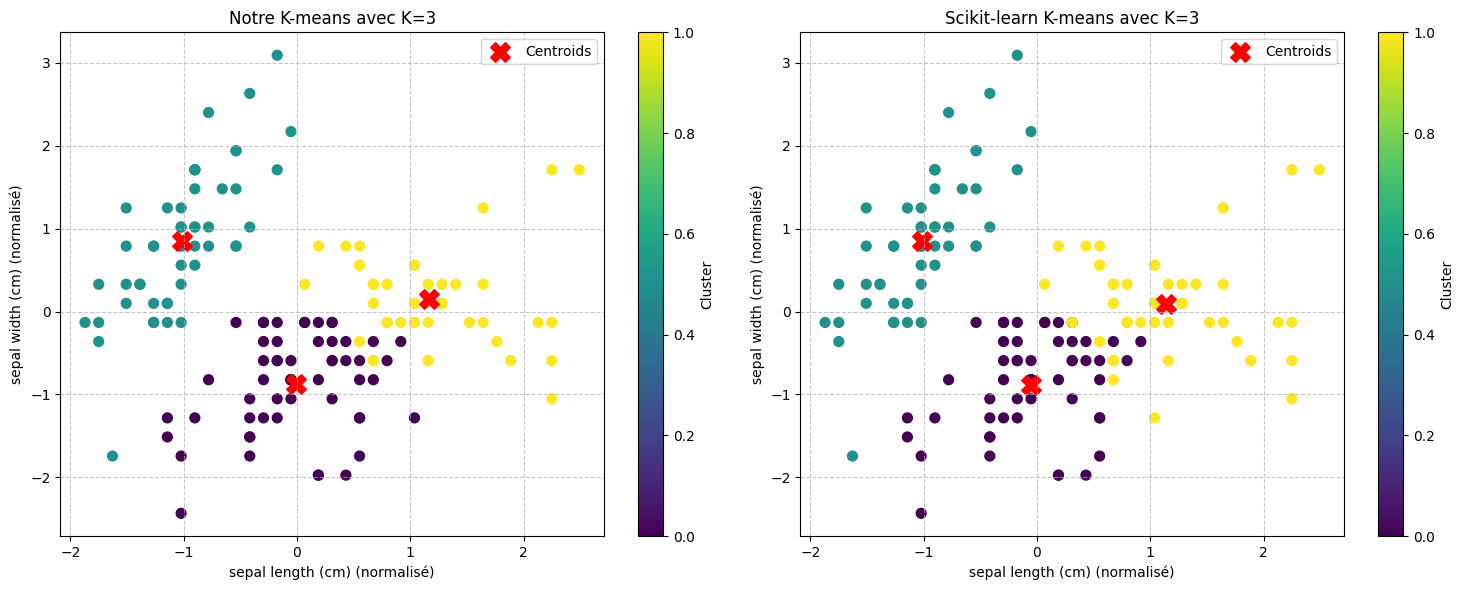


Distribution des espèces dans chaque cluster:
Notre implémentation:
Species   0   1   2
Cluster            
0         0  39  17
1        50   0   0
2         0  11  33

Implémentation scikit-learn:
Species   0   1   2
Cluster            
0         0  39  14
1        50   0   0
2         0  11  36

=== Tests avec K = 2 ===

Notre implémentation de K-means:
Adjusted Rand Index: 0.5681
Inertie: 222.3617
Score de silhouette: 0.5818

Implémentation scikit-learn de K-means:
Adjusted Rand Index: 0.5681
Inertie: 222.3617
Score de silhouette: 0.5818


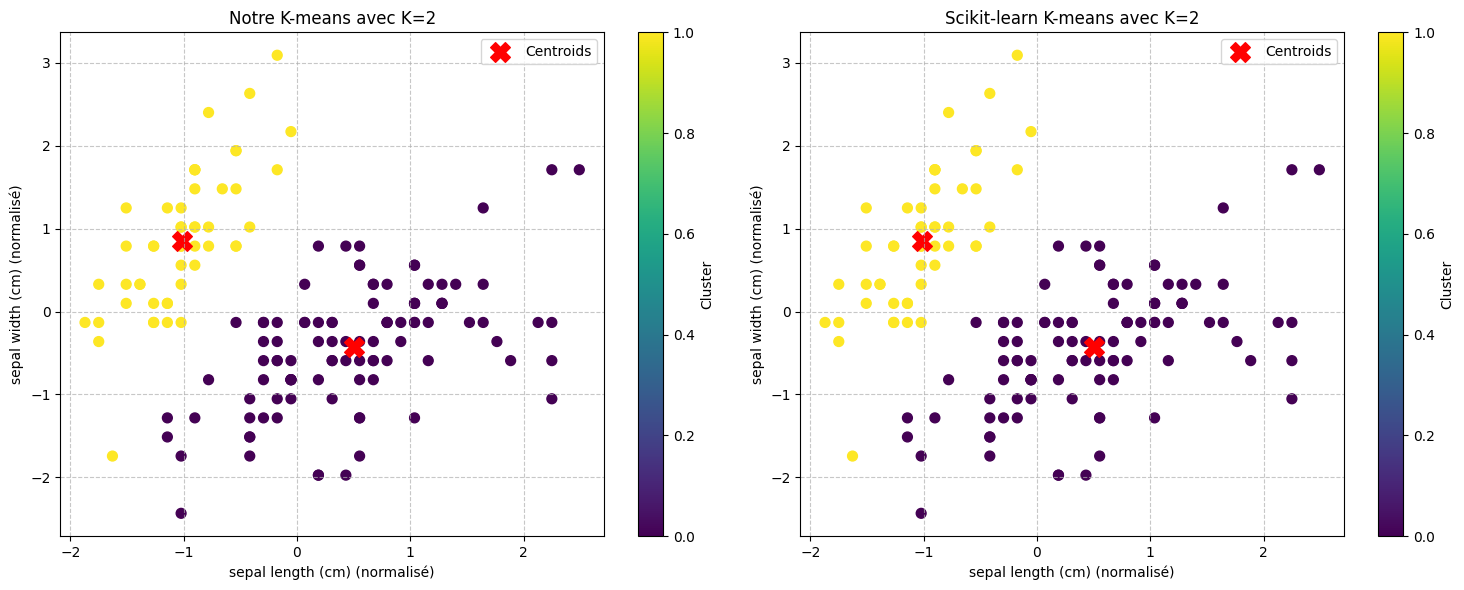


Distribution des espèces dans chaque cluster:
Notre implémentation:
Species   0   1   2
Cluster            
0         0  50  50
1        50   0   0

Implémentation scikit-learn:
Species   0   1   2
Cluster            
0         0  50  50
1        50   0   0

Résumé des résultats:
   K                  Impl       ARI     Inertia  Silhouette
0  3         Notre K-means  0.592333  140.032753    0.463042
1  3  Scikit-learn K-means  0.620135  139.820496    0.459948
2  2         Notre K-means  0.568116  222.361705    0.581750
3  2  Scikit-learn K-means  0.568116  222.361705    0.581750

Analyse comparative:
Pour K = 3:
  Différence d'ARI: -0.0278 (positif = notre implémentation est meilleure)
  Différence d'Inertie: 0.2123 (négatif = notre implémentation est meilleure)
  Différence de Silhouette: 0.0031 (positif = notre implémentation est meilleure)
Pour K = 2:
  Différence d'ARI: 0.0000 (positif = notre implémentation est meilleure)
  Différence d'Inertie: 0.0000 (négatif = notre implémenta

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans as SKLearnKMeans

class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        """
        Initialize KMeans algorithm.

        Parameters:
        -----------
        n_clusters : int, default=3
            Number of clusters to form.
        max_iter : int, default=100
            Maximum number of iterations of the algorithm.
        tol : float, default=1e-4
            Relative tolerance with regards to inertia to declare convergence.
        random_state : int, default=None
            Seed for random number generator.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        """
        Compute k-means clustering.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training instances to cluster.

        Returns:
        --------
        self : object
            Fitted estimator.
        """
        # Set random state for reproducibility
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Get dimensions of data
        n_samples, n_features = X.shape

        # Initialize centroids by randomly selecting from data points
        # Following Algorithm 1 in the PDF, line 1
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        # Initialize labels
        old_labels = np.zeros(n_samples)

        # Iterative algorithm (lines 2-8 in Algorithm 1)
        for iteration in range(self.max_iter):
            # Calculate distances between all points and all centroids
            distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :]) ** 2).sum(axis=2))

            # Assign each point to the nearest centroid (line 4)
            self.labels_ = np.argmin(distances, axis=1)

            # Check for convergence (if labels haven't changed)
            if np.all(old_labels == self.labels_):
                break

            old_labels = self.labels_.copy()

            # Update centroids based on new cluster assignments (line 6)
            for k in range(self.n_clusters):
                if np.sum(self.labels_ == k) > 0:  # Avoid empty clusters
                    self.centroids[k] = np.mean(X[self.labels_ == k], axis=0)

        # Calculate inertia (sum of squared distances to closest centroid)
        # This corresponds to J in equation (1) of the PDF
        self.inertia_ = 0
        for k in range(self.n_clusters):
            cluster_points = X[self.labels_ == k]
            if len(cluster_points) > 0:
                self.inertia_ += np.sum((cluster_points - self.centroids[k]) ** 2)

        return self

    def predict(self, X):
        """
        Predict the closest cluster each sample in X belongs to.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            New data to predict.

        Returns:
        --------
        labels : array of shape (n_samples,)
            Index of the cluster each sample belongs to.
        """
        # Calculate distances between all points and all centroids
        distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :]) ** 2).sum(axis=2))

        # Return cluster index for each point
        return np.argmin(distances, axis=1)


# 1. Charger le dataset Iris
print("Chargement du dataset Iris...")
iris = load_iris()
X = iris.data
y_true = iris.target

# Créer un DataFrame pour une meilleure visualisation des données
iris_df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                      columns=iris['feature_names'] + ['target'])
print("Aperçu des données Iris:")
print(iris_df.head())
print(f"Dimensions du dataset: {X.shape}")
print(f"Nombre réel d'espèces dans le dataset: 3 (setosa, versicolor, virginica)")

# 2. Normaliser les données
print("\nNormalisation des données...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Détermination du nombre de clusters par la méthode du coude et de la silhouette
print("\n=== Détermination du nombre optimal de clusters ===")
wcss = []  # Within-Cluster Sum of Squares (WCSS) ou inertie
silhouette_scores = []  # Scores de silhouette pour chaque K
k_range = range(1, 11)  # Tester de 1 à 10 clusters

# Calculer l'inertie et le score de silhouette pour différentes valeurs de K
for k in k_range:
    # Utiliser scikit-learn pour calculer les métriques
    kmeans = SKLearnKMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    # Calculer le score de silhouette (pas disponible pour k=1)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    else:
        silhouette_scores.append(0)  # Silhouette non définie pour k=1

# Tracer les deux métriques en fonction de K
plt.figure(figsize=(15, 6))

# Méthode du coude
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-')
plt.title('Méthode du coude (WCSS)', fontsize=14)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('WCSS (inertie)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

coude_k = 3  # inspection visuelle du graphique

plt.annotate(f'Coude visuel à k={coude_k}',
             xy=(coude_k, wcss[coude_k-1]),
             xytext=(coude_k+1, wcss[coude_k-1]+10),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Ajouter une référence pour K=3 (nombre réel d'espèces)
plt.axvline(x=3, color='r', linestyle='--', alpha=0.5)
plt.annotate('K réel = 3',
             xy=(3, wcss[2]),
             xytext=(3.5, wcss[2]+20),
             arrowprops=dict(facecolor='red', shrink=0.05))

# Indice de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'ro-')  # Commencer à k=2
plt.title('Indice de silhouette moyen', fontsize=14)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Indice de silhouette', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Identifier le k avec le meilleur score de silhouette
best_silhouette_k = np.argmax(silhouette_scores[1:]) + 2  # +2 car on commence à k=2

plt.annotate(f'Meilleur k={best_silhouette_k}',
             xy=(best_silhouette_k, silhouette_scores[best_silhouette_k-1]),
             xytext=(best_silhouette_k+1, silhouette_scores[best_silhouette_k-1]-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Ajouter une référence pour K=3 (nombre réel d'espèces)
plt.axvline(x=3, color='r', linestyle='--', alpha=0.5)
plt.annotate('K réel = 3',
             xy=(3, silhouette_scores[2]),
             xytext=(3.5, silhouette_scores[2]-0.05),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.tight_layout()
plt.savefig('iris_elbow_silhouette_method.png')
plt.show()

# Résultats numériques et analyse
print("\nRésultats de l'analyse:")
print("K | WCSS (inertie) | Silhouette")
print("-" * 40)
for k in k_range:
    print(f"{k} | {wcss[k-1]:.2f} | {silhouette_scores[k-1]:.4f}")

print(f"\nMéthode du coude: K optimal = {coude_k}")
print(f"Méthode de la silhouette: K optimal = {best_silhouette_k}")
print(f"Nombre réel d'espèces: 3")

# Analyse des résultats et comparaison avec le nombre réel d'espèces
if coude_k == 3 and best_silhouette_k == 3:
    print("Les deux méthodes identifient correctement le nombre réel d'espèces (K=3).")
    optimal_k = 3
elif coude_k == 3:
    print("La méthode du coude identifie correctement le nombre réel d'espèces (K=3).")
    print(f"La méthode de la silhouette suggère K={best_silhouette_k}, ce qui diffère du nombre réel.")
    print("Nous retenons K=3 basé sur la connaissance du dataset et la méthode du coude.")
    optimal_k = 3
elif best_silhouette_k == 3:
    print("La méthode de la silhouette identifie correctement le nombre réel d'espèces (K=3).")
    print(f"La méthode du coude suggère K={coude_k}, ce qui diffère du nombre réel.")
    print("Nous retenons K=3 basé sur la connaissance du dataset et la méthode de la silhouette.")
    optimal_k = 3
else:
    print(f"Ni la méthode du coude (K={coude_k}) ni la méthode de la silhouette (K={best_silhouette_k}) n'identifient correctement le nombre réel d'espèces (K=3).")
    print("Pour ce dataset, nous savons qu'il y a 3 espèces, donc nous retenons K=3.")
    optimal_k = 3

print(f"\nNombre optimal de clusters retenu: K={optimal_k}")

# Pour l'analyse, nous allons tester avec le K optimal et comparer avec un K différent
k_values = [optimal_k, 2 if optimal_k != 2 else 4]

# 4. Entrainer les modèles et évaluer les performances pour chaque K
results = []

for k in k_values:
    print(f"\n=== Tests avec K = {k} ===")

    # A. Notre implémentation de K-means
    print("\nNotre implémentation de K-means:")
    custom_model = KMeans(n_clusters=k, random_state=42, max_iter=100)
    custom_model.fit(X_scaled)
    custom_pred = custom_model.labels_

    # Calculer les métriques d'évaluation
    custom_ari = adjusted_rand_score(y_true, custom_pred)
    custom_inertia = custom_model.inertia_

    # Calculer le score de silhouette
    custom_silhouette = silhouette_score(X_scaled, custom_pred) if k > 1 else 0

    print(f"Adjusted Rand Index: {custom_ari:.4f}")
    print(f"Inertie: {custom_inertia:.4f}")
    print(f"Score de silhouette: {custom_silhouette:.4f}")

    # B. Implémentation scikit-learn de K-means
    print("\nImplémentation scikit-learn de K-means:")
    sklearn_model = SKLearnKMeans(n_clusters=k, random_state=42, n_init=10)
    sklearn_model.fit(X_scaled)
    sklearn_pred = sklearn_model.labels_

    # Calculer les métriques d'évaluation
    sklearn_ari = adjusted_rand_score(y_true, sklearn_pred)
    sklearn_inertia = sklearn_model.inertia_

    # Calculer le score de silhouette
    sklearn_silhouette = silhouette_score(X_scaled, sklearn_pred) if k > 1 else 0

    print(f"Adjusted Rand Index: {sklearn_ari:.4f}")
    print(f"Inertie: {sklearn_inertia:.4f}")
    print(f"Score de silhouette: {sklearn_silhouette:.4f}")

    # Stocker les résultats
    results.append({
        'K': k,
        'Impl': 'Notre K-means',
        'ARI': custom_ari,
        'Inertia': custom_inertia,
        'Silhouette': custom_silhouette
    })
    results.append({
        'K': k,
        'Impl': 'Scikit-learn K-means',
        'ARI': sklearn_ari,
        'Inertia': sklearn_inertia,
        'Silhouette': sklearn_silhouette
    })

    # 5. Visualiser les clusters et les centroïdes pour les deux implémentations
    plt.figure(figsize=(15, 6))

    # Notre implémentation
    plt.subplot(1, 2, 1)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=custom_pred, cmap='viridis', s=50)
    plt.scatter(custom_model.centroids[:, 0], custom_model.centroids[:, 1],
                c='red', marker='X', s=200, label='Centroids')
    plt.title(f'Notre K-means avec K={k}')
    plt.xlabel(f"{iris.feature_names[0]} (normalisé)")
    plt.ylabel(f"{iris.feature_names[1]} (normalisé)")
    plt.colorbar(label='Cluster')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Scikit-learn implémentation
    plt.subplot(1, 2, 2)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=sklearn_pred, cmap='viridis', s=50)
    plt.scatter(sklearn_model.cluster_centers_[:, 0], sklearn_model.cluster_centers_[:, 1],
                c='red', marker='X', s=200, label='Centroids')
    plt.title(f'Scikit-learn K-means avec K={k}')
    plt.xlabel(f"{iris.feature_names[0]} (normalisé)")
    plt.ylabel(f"{iris.feature_names[1]} (normalisé)")
    plt.colorbar(label='Cluster')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'iris_kmeans_comparison_k{k}.png')
    plt.show()

    # 6. Analyser la distribution des espèces réelles dans chaque cluster
    print("\nDistribution des espèces dans chaque cluster:")

    print("Notre implémentation:")
    custom_cluster_species = pd.DataFrame({
        'Cluster': custom_pred,
        'Species': y_true
    })
    custom_distribution = pd.crosstab(
        custom_cluster_species['Cluster'],
        custom_cluster_species['Species'],
        rownames=['Cluster'],
        colnames=['Species']
    )
    print(custom_distribution)

    print("\nImplémentation scikit-learn:")
    sklearn_cluster_species = pd.DataFrame({
        'Cluster': sklearn_pred,
        'Species': y_true
    })
    sklearn_distribution = pd.crosstab(
        sklearn_cluster_species['Cluster'],
        sklearn_cluster_species['Species'],
        rownames=['Cluster'],
        colnames=['Species']
    )
    print(sklearn_distribution)

# 7. Résumé des résultats
results_df = pd.DataFrame(results)
print("\nRésumé des résultats:")
print(results_df)

# 8. Comparer les performances des deux implémentations
print("\nAnalyse comparative:")

# Calculer les différences de performance
for k in k_values:
    custom_results = results_df[(results_df['K'] == k) & (results_df['Impl'] == 'Notre K-means')]
    sklearn_results = results_df[(results_df['K'] == k) & (results_df['Impl'] == 'Scikit-learn K-means')]

    ari_diff = custom_results['ARI'].values[0] - sklearn_results['ARI'].values[0]
    inertia_diff = custom_results['Inertia'].values[0] - sklearn_results['Inertia'].values[0]
    silhouette_diff = custom_results['Silhouette'].values[0] - sklearn_results['Silhouette'].values[0]

    print(f"Pour K = {k}:")
    print(f"  Différence d'ARI: {ari_diff:.4f} (positif = notre implémentation est meilleure)")
    print(f"  Différence d'Inertie: {inertia_diff:.4f} (négatif = notre implémentation est meilleure)")
    print(f"  Différence de Silhouette: {silhouette_diff:.4f} (positif = notre implémentation est meilleure)")

# 9. Conclusion globale
print("\nConclusion:")
best_k_ari = results_df.groupby('K')['ARI'].mean().idxmax()
best_k_silhouette = results_df.groupby('K')['Silhouette'].mean().idxmax()
best_k_inertia = results_df.groupby('K')['Inertia'].mean().idxmin()

print(f"Meilleur K selon ARI (moyenne des deux implémentations): K = {best_k_ari}")
print(f"Meilleur K selon Silhouette (moyenne des deux implémentations): K = {best_k_silhouette}")
print(f"Meilleur K selon Inertie (moyenne des deux implémentations): K = {best_k_inertia}")

# Vérifier si les métriques concordent
if best_k_ari == best_k_silhouette == best_k_inertia:
    print(f"Toutes les métriques suggèrent que K = {best_k_ari} est le meilleur choix pour ce dataset.")
else:
    print("Les métriques ne concordent pas sur le meilleur K.")
    print(f"Pour le dataset Iris, nous savons qu'il y a 3 espèces, donc le nombre optimal de clusters devrait être K=3.")
    if 3 in [best_k_ari, best_k_silhouette, best_k_inertia]:
        print(f"Au moins une des métriques a correctement identifié K=3 comme le nombre optimal.")
    else:
        print(f"Aucune des métriques n'a identifié K=3 comme le nombre optimal.")
